## RAG Agent



In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs, json_render

load_env()

True

In [ ]:
from stringdale import V,E,Define
from stringdale.chat import Chat
from stringdale.db import ChromaClient

In [ ]:
chroma_client = ChromaClient()

In [ ]:
dog_docs = [
    {
        'id': 'dog1',
        'text': 'The Golden Retriever is a friendly, intelligent breed known for its golden coat. They make excellent family pets and are great with children.',
        'metadata': {'breed': 'Golden Retriever'}
    },
    {
        'id': 'dog2', 
        'text': 'German Shepherds are loyal, protective dogs often used in police work. They are highly trainable and good at various tasks.',
        'metadata': {'breed': 'German Shepherd'}
    },
    {
        'id': 'dog3',
        'text': 'The Golden Retriever is a friendly, intelligent breed with a beautiful golden coat. They are wonderful family pets that get along well with kids.',
        'metadata': {'breed': 'Golden Retriever'}  # Near duplicate of dog1
    },
    {
        'id': 'dog4',
        'text': 'Huskies are energetic working dogs bred for cold climates. They have thick fur and often blue eyes.',
        'metadata': {'breed': 'Husky'}
    },
    {
        'id': 'dog5',
        'text': 'Siberian Huskies are active working dogs that thrive in cold weather. They are known for their thick coats and striking blue eyes.',
        'metadata': {'breed': 'Husky'}  # Near duplicate of dog4
    }
]

# Add documents to index
chroma_client.add_collection("dog_docs",exists_ok=True)
chroma_client.upsert(collection_name="dog_docs",docs=dog_docs)

[{'id': 'dog1',
  'text': 'The Golden Retriever is a friendly, intelligent breed known for its golden coat. They make excellent family pets and are great with children.',
  'metadata': {'breed': 'Golden Retriever'}},
 {'id': 'dog2',
  'text': 'German Shepherds are loyal, protective dogs often used in police work. They are highly trainable and good at various tasks.',
  'metadata': {'breed': 'German Shepherd'}},
 {'id': 'dog3',
  'text': 'The Golden Retriever is a friendly, intelligent breed with a beautiful golden coat. They are wonderful family pets that get along well with kids.',
  'metadata': {'breed': 'Golden Retriever'}},
 {'id': 'dog4',
  'text': 'Huskies are energetic working dogs bred for cold climates. They have thick fur and often blue eyes.',
  'metadata': {'breed': 'Husky'}},
 {'id': 'dog5',
  'text': 'Siberian Huskies are active working dogs that thrive in cold weather. They are known for their thick coats and striking blue eyes.',
  'metadata': {'breed': 'Husky'}}]

In [ ]:
rag_chat = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
            You are a helpful assistant that answers questions about dogs.
            I found the following documents that may be relevant to the user's question:
            {% for doc in docs %}
            {{doc['text']}}
            {% endfor %}
            '''},
        {'role':'user','content':'{{question}}'},
    ]
)
rag_chat

Chat(model='gpt-4o-mini', required_keys={'docs', 'question'}, seed=42)

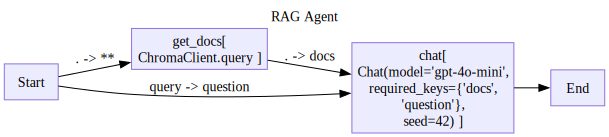

In [ ]:
with Define('RAG Agent',type='flow') as RAG:
    V('get_docs',chroma_client.query,
        inputs=['Start(**)'],
    )
    V('chat',rag_chat,
        inputs=['get_docs(docs)','Start(question=query)'],
        outputs=['End']
    )
    
RAG.draw()

In [ ]:
d=RAG()
for trace in d.run({'query':'tell me some stuff about golden retrievers','collection_name':'dog_docs','k':2}):
    trace.pprint()

d.output


Node Start:
{ 'input': { 'collection_name': 'dog_docs',
             'k': 2,
             'query': 'tell me some stuff about golden retrievers'},
  'output': { 'collection_name': 'dog_docs',
              'k': 2,
              'query': 'tell me some stuff about golden retrievers'}}
Node get_docs:
{ 'input': { 'collection_name': 'dog_docs',
             'k': 2,
             'query': 'tell me some stuff about golden retrievers'},
  'output': [ { 'distance': 0.6993070840835571,
                'id': 'dog3',
                'metadata': {'breed': 'Golden Retriever'},
                'text': 'The Golden Retriever is a friendly, intelligent breed '
                        'with a beautiful golden coat. They are wonderful '
                        'family pets that get along well with kids.'},
              { 'distance': 0.7122190594673157,
                'id': 'dog1',
                'metadata': {'breed': 'Golden Retriever'},
                'text': 'The Golden Retriever is a friendly, intel

{'role': 'assistant',
 'content': 'The Golden Retriever is a friendly and intelligent breed known for its beautiful golden coat. They make excellent family pets and are particularly good with children, making them wonderful companions for families.',
 'meta': {'input_tokens': 198, 'output_tokens': 42}}